# Calulate the  Fosberg Fire Weather Index (FFWI) from monthly CMIP output

$$ FFWI = \frac{\eta \sqrt{1+U^2}}{0.3002}$$

with $U$ as wind speed in [mph] (`sfcWind` CMIP variable)

and 

$$ \eta = 1 - 2 \cdot \left( \frac{EMC}{30} \right) + 1.5 \cdot \left( \frac{EMC}{30} \right)^2 - 0.5 \cdot \left( \frac{EMC}{30} \right)^3$$

where EMC is the equilibrium moisture content [mm]

[source](https://wikifire.wsl.ch/tiki-indexe575.html?page=Fosberg+fire+weather+index)

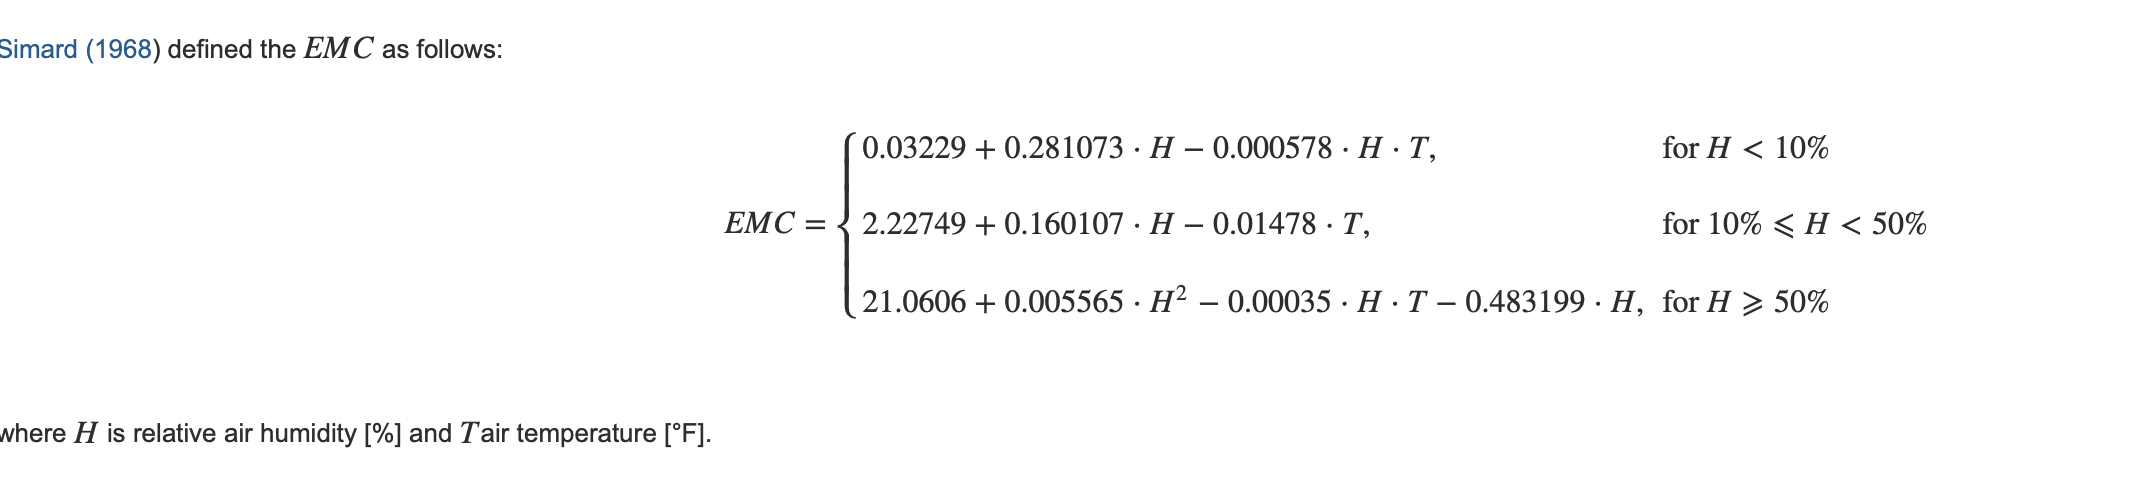

[source](https://wikifire.wsl.ch/tiki-indexf2f0.html?page=Equilibrium+moisture+content)


Value Range Interpretation: 

20-30: High danger
30+: Extreme danger
[source](http://map.disarmfire.eu/About)

## Define Index
Numba helps to speed this up tremendously.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
from numba import vectorize, float64

@vectorize([float64(float64, float64)])
def EMC_point(temp, rel_humidity):
    if rel_humidity < 10:
        return 0.03229 + 0.281073 * rel_humidity - 0.000578 * rel_humidity * temp
    elif rel_humidity >= 50:
        return 21.0606 + 0.005565 * rel_humidity**2 - 0.00035 * rel_humidity * temp - 0.483199 * rel_humidity
    else:
        return 2.22749 + 0.160107 * rel_humidity - 0.01478 * temp

def EMC(temp, rel_humidity):
    return xr.apply_ufunc(EMC_point, temp, rel_humidity, dask='parallelized')

    
def FFWI(temp, rel_humidity, wind_speed):
    # convert wind speed from m/s to mph
    wind_speed = wind_speed * 2.23694
    # convert temp (K->F)
    temp = (temp - 273.15) * 9/5 + 32
    
    emc = EMC(temp, rel_humidity)
    
    a = emc/30
    
    eta = 1 - (2 * a) + (1.5 *  a**2) - (0.5 * a**3)
    
    ffwi = eta * np.sqrt(1+(wind_speed**2)) / 0.3002
    
    return ffwi

## Search and load the CMIP6 data from GCS

In [15]:
from xmip.utils import google_cmip_col
col = google_cmip_col()
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [18]:
cat = col.search(
    variable_id=['hurs', 'tas', 'sfcWind'],
    table_id='Amon',
    member_id='r2i1p1f1', # single member to keep the amount of data down
    experiment_id=['historical', 'ssp585'],
    require_all_on=['source_id', 'grid_label'],
)

cat.df.groupby(['source_id']).nunique()


,activity_id,institution_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
source_id,,,,,,,,,,
ACCESS-CM2,2,1,2,1,1,3,1,6,0,2
ACCESS-ESM1-5,2,1,2,1,1,3,1,6,0,2
CESM2-WACCM,2,1,2,1,1,3,1,6,0,2
CanESM5,2,1,2,1,1,3,1,6,0,1
EC-Earth3-Veg,2,1,2,1,1,3,1,6,0,1
EC-Earth3-Veg-LR,2,1,2,1,1,3,1,6,0,2
FGOALS-g3,2,1,2,1,1,3,1,6,0,2
FIO-ESM-2-0,2,1,2,1,1,3,1,6,0,4
IPSL-CM6A-LR,2,1,2,1,1,3,1,6,0,2


Ok that is a decent amount of models available

In [19]:
from xmip.preprocessing import combined_preprocessing
# @anderson : If we can implement https://github.com/intake/intake-esm/issues/562 
# this would get a bit cleaner (would also help me with another project)
cat.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt = cat.to_datatree(
    aggregate=True,
    xarray_open_kwargs=dict(use_cftime=True),
    xarray_combine_by_coords_kwargs=dict(compat='override', coords='minimal'),
    preprocess=combined_preprocessing,
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


In [20]:
def ffwi_wrapper(ds):
    return FFWI(ds.tas, ds.hurs, ds.sfcWind).to_dataset(name='ffwi')

dt_ffwi = dt.map_over_subtree(ffwi_wrapper)
dt_ffwi


DataTree('None', parent=None)
├── DataTree('IPSL-CM6A-LR')
│   ├── DataTree('historical')
│   │       Dimensions:         (y: 143, x: 144, time: 1980, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │           height          float64 2.0
│   │         * y               (y) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
│   │         * x               (x) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
│   │         * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│   │           lon             (x, y) float32 360.0 360.0 360.0 360.0 ... 357.5 357.5 357.5
│   │           lat             (x, y) float32 -90.0 -88.73 -87.46 ... 87.46 88.73 90.0
│   │         * member_id       (member_id) object 'r2i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           ffwi            (member_id, dcpp_init_year, time, y, x) float64 dask.array<chunksize=(1, 1, 600, 143, 144), meta=np.ndarray>
│   └── DataTree('ssp585')
│           Dimensions:         (y: 143, x: 144, time: 1032, member_id: 1, dcpp_init_year: 1)
│           Coordinates:
│               height          float64 2.0
│             * y               (y) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
│             * x               (x) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
│             * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│               lon             (x, y) float32 360.0 360.0 360.0 360.0 ... 357.5 357.5 357.5
│               lat             (x, y) float32 -90.0 -88.73 -87.46 ... 87.46 88.73 90.0
│             * member_id       (member_id) object 'r2i1p1f1'
│             * dcpp_init_year  (dcpp_init_year) float64 nan
│           Data variables:
│               ffwi            (member_id, dcpp_init_year, time, y, x) float64 dask.array<chunksize=(1, 1, 516, 143, 144), meta=np.ndarray>
├── DataTree('CanESM5')
│   ├── DataTree('historical')
│   │       Dimensions:         (y: 64, x: 128, time: 1980, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │           height          float64 2.0
│   │         * y               (y) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
│   │         * x               (x) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
│   │         * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│   │           lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 357.2 357.2 357.2
│   │           lat             (x, y) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
│   │         * member_id       (member_id) object 'r2i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           ffwi            (member_id, dcpp_init_year, time, y, x) float64 dask.array<chunksize=(1, 1, 600, 64, 128), meta=np.ndarray>
│   └── DataTree('ssp585')
│           Dimensions:         (y: 64, x: 128, time: 1032, member_id: 1, dcpp_init_year: 1)
│           Coordinates:
│               height          float64 2.0
│             * y               (y) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
│             * x               (x) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
│             * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│               lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 357.2 357.2 357.2
│               lat             (x, y) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
│             * member_id       (member_id) object 'r2i1p1f1'
│             * dcpp_init_year  (dcpp_init_year) float64 nan
│           Data variables:
│               ffwi            (member_id, dcpp_init_year, time, y, x) float64 dask.array<chunksize=(1, 1, 516, 64, 128), meta=np.ndarray>
├── DataTree('ACCESS-ESM1-5')
│   ├── DataTree('historical')
│   │       Dimensions:         (y: 145, x: 192, time: 1980, member_id: 1, dcpp_init_year: 1)
│   │       Coordi

### That should be it for the data processing?

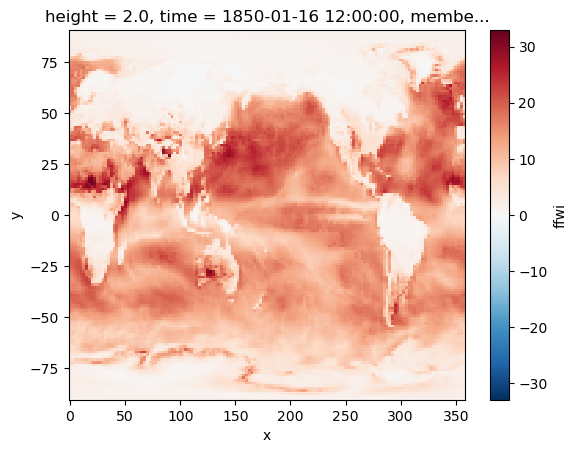

In [13]:
dt_ffwi['IPSL-CM6A-LR']['historical'].ds.isel(time=0).ffwi.squeeze().plot()

In [10]:
# # ds_historical = ddict['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.day.gn']
# # ds_ssp = ddict['ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.day.gn']

# ds_historical = ddict['CMIP.CCCma.CanESM5.historical.day.gn']
# ds_ssp = ddict['ScenarioMIP.CCCma.CanESM5.ssp585.day.gn']
# # concat both later
# ds = xr.concat([ds_historical, ds_ssp], dim='time')
# ds

In [11]:
# ffwi = FFWI(ds['tas'], ds['hurs'], ds['sfcWind'])
# ffwi

In [12]:
# ffwi_annual = ffwi.coarsen(time=360, boundary='trim').mean().squeeze().load()
# ffwi_annual.nbytes/1e9

In [13]:
# ffwi_trend = ffwi_annual.polyfit(dim='time', deg=1).load()
# ffwi_trend.polyfit_coefficients.sel(degree=1).plot(vmax=1e-18)

In [20]:
dt_ffwi

DataTree('None', parent=None)
├── DataTree('IPSL-CM6A-LR')
│   ├── DataTree('historical')
│   │       Dimensions:         (y: 143, x: 144, time: 1980, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │           height          float64 2.0
│   │         * y               (y) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
│   │         * x               (x) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
│   │         * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│   │           lon             (x, y) float32 360.0 360.0 360.0 360.0 ... 357.5 357.5 357.5
│   │           lat             (x, y) float32 -90.0 -88.73 -87.46 ... 87.46 88.73 90.0
│   │         * member_id       (member_id) object 'r2i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           ffwi            (member_id, dcpp_init_year, time, y, x) float64 dask.array<chunksize=(1, 1, 600, 143, 144), meta=np.ndarray>
│   └── DataTree('ssp585')
│           Dimensions:         (y: 143, x: 144, time: 1032, member_id: 1, dcpp_init_year: 1)
│           Coordinates:
│               height          float64 2.0
│             * y               (y) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
│             * x               (x) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
│             * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│               lon             (x, y) float32 360.0 360.0 360.0 360.0 ... 357.5 357.5 357.5
│               lat             (x, y) float32 -90.0 -88.73 -87.46 ... 87.46 88.73 90.0
│             * member_id       (member_id) object 'r2i1p1f1'
│             * dcpp_init_year  (dcpp_init_year) float64 nan
│           Data variables:
│               ffwi            (member_id, dcpp_init_year, time, y, x) float64 dask.array<chunksize=(1, 1, 516, 143, 144), meta=np.ndarray>
├── DataTree('ACCESS-ESM1-5')
│   ├── DataTree('ssp585')
│   │       Dimensions:         (y: 145, x: 192, time: 3432, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │           height          float64 2.0
│   │         * y               (y) float64 -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
│   │         * x               (x) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2300-12-16 12:00:00
│   │           lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.1 358.1 358.1
│   │           lat             (x, y) float64 -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
│   │         * member_id       (member_id) object 'r2i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           ffwi            (member_id, dcpp_init_year, time, y, x) float64 dask.array<chunksize=(1, 1, 515, 145, 192), meta=np.ndarray>
│   └── DataTree('historical')
│           Dimensions:         (y: 145, x: 192, time: 1980, member_id: 1, dcpp_init_year: 1)
│           Coordinates:
│               height          float64 2.0
│             * y               (y) float64 -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
│             * x               (x) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
│             * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│               lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.1 358.1 358.1
│               lat             (x, y) float64 -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
│             * member_id       (member_id) object 'r2i1p1f1'
│             * dcpp_init_year  (dcpp_init_year) float64 nan
│           Data variables:
│               ffwi            (member_id, dcpp_init_year, time, y, x) float64 dask.array<chunksize=(1, 1, 514, 145, 192), meta=np.ndarray>
├── DataTree('FGOALS-g3')
│   ├── DataTree('ssp585')
│   │       Dimensions:         (y: 80, x: 180, time: 1032, member_id: 1, dcpp_init_year: 1)
│

In [30]:
import xesmf as xe
# Coordinates of Perth, AUS
ds_location = xr.Dataset(coords={'lon':[115.8613], 'lat':[-31.9523]}) 
def extract_location_timeseries(ds):
    regridder = xe.Regridder(ds, ds_location, 'bilinear')
    ds_timeseries = regridder(ds)
    return ds_timeseries.squeeze().load().resample(time='5AS').apply(lambda da: da.quantile(0.9))

with ProgressBar():
    dt_timeseries = dt_ffwi.map_over_subtree(extract_location_timeseries)
dt_timeseries

[########################################] | 100% Completed | 1.72 sms
[########################################] | 100% Completed | 1.21 sms
[########################################] | 100% Completed | 2.74 sms
[########################################] | 100% Completed | 2.02 sms
[########################################] | 100% Completed | 811.08 ms
[########################################] | 100% Completed | 1.41 sms
[########################################] | 100% Completed | 2.84 sms
[########################################] | 100% Completed | 1.82 sms
[########################################] | 100% Completed | 1.83 sms
[########################################] | 100% Completed | 808.67 ms
[########################################] | 100% Completed | 4.16 ss
[########################################] | 100% Completed | 2.64 ss
[########################################] | 100% Completed | 2.03 sms
[########################################] | 100% Completed | 3.25 sms
[#####

DataTree('None', parent=None)
├── DataTree('IPSL-CM6A-LR')
│   ├── DataTree('historical')
│   │       Dimensions:   (time: 33)
│   │       Coordinates:
│   │           quantile  float64 0.9
│   │         * time      (time) object 1850-01-01 00:00:00 ... 2010-01-01 00:00:00
│   │       Data variables:
│   │           ffwi      (time) float64 18.62 19.48 18.93 18.51 ... 20.61 20.7 20.18 19.43
│   └── DataTree('ssp585')
│           Dimensions:   (time: 18)
│           Coordinates:
│               quantile  float64 0.9
│             * time      (time) object 2015-01-01 00:00:00 ... 2100-01-01 00:00:00
│           Data variables:
│               ffwi      (time) float64 19.85 19.56 20.15 19.44 ... 21.51 22.15 19.67 20.26
├── DataTree('ACCESS-ESM1-5')
│   ├── DataTree('ssp585')
│   │       Dimensions:   (time: 58)
│   │       Coordinates:
│   │           quantile  float64 0.9
│   │         * time      (time) object 2015-01-01 00:00:00 ... 2300-01-01 00:00:00
│   │       Data variables:
│   │           ffwi      (time) float64 22.24 21.59 20.9 21.77 ... 23.47 23.61 23.16 21.46
│   └── DataTree('historical')
│           Dimensions:   (time: 33)
│           Coordinates:
│               quantile  float64 0.9
│             * time      (time) object 1850-01-01 00:00:00 ... 2010-01-01 00:00:00
│           Data variables:
│               ffwi      (time) float64 20.96 20.14 20.46 20.28 ... 21.85 20.81 21.49 22.41
├── DataTree('FGOALS-g3')
│   ├── DataTree('ssp585')
│   │       Dimensions:   (time: 18)
│   │       Coordinates:
│   │           quantile  float64 0.9
│   │         * time      (time) object 2015-01-01 00:00:00 ... 2100-01-01 00:00:00
│   │       Data variables:
│   │           ffwi      (time) float64 22.8 22.41 22.41 22.15 ... 23.65 24.18 24.28 24.19
│   └── DataTree('historical')
│           Dimensions:   (time: 34)
│           Coordinates:
│               quantile  float64 0.9
│             * time      (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
│           Data variables:
│               ffwi      (time) float64 19.67 19.38 19.45 19.36 ... 22.99 22.3 23.02 23.23
├── DataTree('EC-Earth3-Veg-LR')
│   ├── DataTree('historical')
│   │       Dimensions:   (time: 33)
│   │       Coordinates:
│   │           quantile  float64 0.9
│   │         * time      (time) object 1850-01-01 00:00:00 ... 2010-01-01 00:00:00
│   │       Data variables:
│   │           ffwi      (time) float64 24.23 22.8 23.76 23.55 ... 28.02 25.67 26.51 25.47
│   └── DataTree('ssp585')
│           Dimensions:   (time: 18)
│           Coordinates:
│               quantile  float64 0.9
│             * time      (time) object 2015-01-01 00:00:00 ... 2100-01-01 00:00:00
│           Data variables:
│               ffwi      (time) float64 26.97 27.64 24.84 25.22 ... 26.78 27.4 28.24 29.22
├── DataTree('MPI-ESM1-2-LR')
│   ├── DataTree('historical')
│   │       Dimensions:   (time: 33)
│   │       Coordinates:
│   │           quantile  float64 0.9
│   │         * time      (time) object 1850-01-01 00:00:00 ... 2010-01-01 00:00:00
│   │       Data variables:
│   │           ffwi      (time) float64 26.87 26.71 25.15 26.18 ... 35.09 35.41 33.89 34.17
│   └── DataTree('ssp585')
│           Dimensions:   (time: 18)
│           Coordinates:
│               quantile  float64 0.9
│             * time      (time) object 2015-01-01 00:00:00 ... 2100-01-01 00:00:00
│           Data variables:
│               ffwi      (time) float64 34.61 34.81 35.15 35.8 ... 38.4 36.63 37.81 37.47
├── DataTree('MPI-ESM1-2-HR')
│   ├── DataTree('historical')
│   │       Dimensions:   (time: 33)
│   │       Coordinates:
│   │           quantile  float64 0.9
│   │         * time      (time) object 1850-01-01 00:00:00 ... 2010-01-01 00:00:00
│   │       Data variables:
│   │           ffwi      (time) float64 23.43 23.82 23.73 23.6 ... 27.41 26.81 26.74 25.92
│   └── DataTree('ssp585')
│           Dimensions:   (time: 18)
│           Coordinates:
│               quantile  float64 0.

In [31]:
color_dict = {model:f'C{i}' for i, model in enumerate(dt_timeseries.keys())}

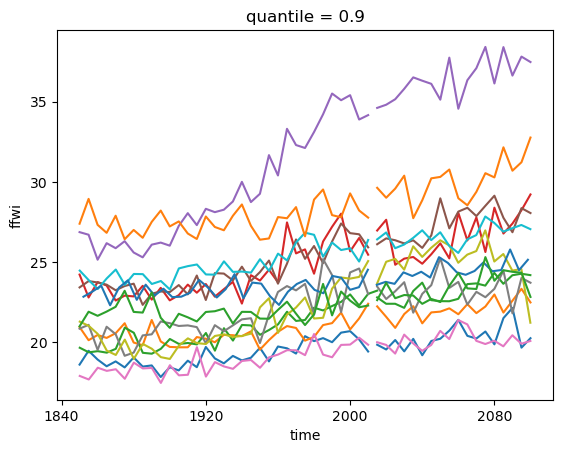

In [32]:
for model, subtree in dt_timeseries.items():
    color = color_dict[model]
    for node in subtree.values():
        ds = node.ds.sel(time=slice(None, '2100'))
        ds.ffwi.plot(color=color)